

**Практика 3: Атака Carlini-Wagner (CW) на модели
ИИ**

**Выполнил: Очередько Антон Николаевич ББМО-01-23**


Шаг 1: Загрузка обученной модели и данных MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot encoding
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9740 - loss: 0.0878
Test accuracy on clean images: 0.9768000245094299


Шаг 2-3: Ознакомление с теорией, установка Foolbox и запуск CW-атаки

In [2]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00


Для изображения с индексом 19, метка: 4


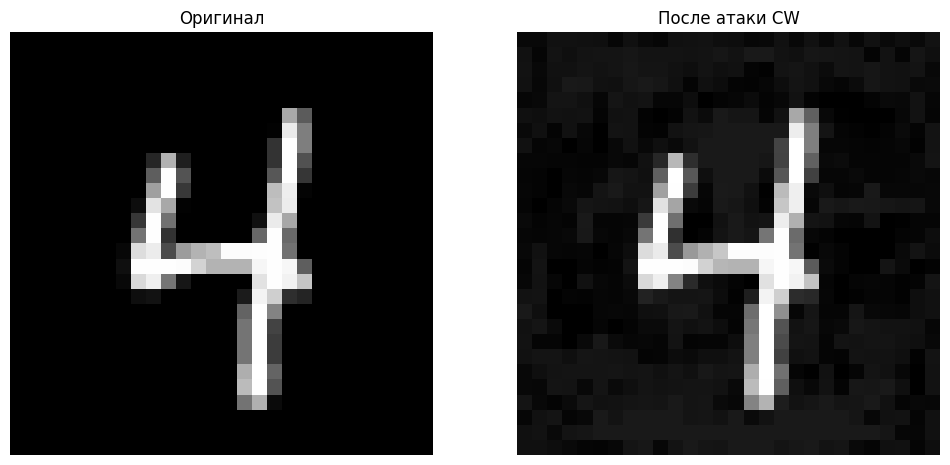

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import foolbox as fb

# Инициализация Foolbox модели
foolbox_model = fb.TensorFlowModel(model, bounds=(-1, 1))

# Получение случайного изображения и метки из тестового набора
idx = random.choice(range(len(test_images)))
input_image = tf.convert_to_tensor(test_images[idx], dtype=tf.float32)[None, ...]
true_label = np.argmax(test_labels[idx])
true_label = tf.convert_to_tensor(true_label, dtype=tf.int64)

# Настройка атаки Carlini-Wagner с L2-нормой
cw_attack = fb.attacks.L2CarliniWagnerAttack(steps=100)

# Выполнение атаки
print(f"Для изображения с индексом {idx}, метка: {true_label.numpy()}")
perturbed_images, _, attack_success = cw_attack(foolbox_model, input_image, true_label[None], epsilons=0.01)

# Визуализация исходного и атакованного изображения
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Исходное изображение
axes[0].imshow(input_image[0].numpy(), cmap='gray')
axes[0].set_title("Оригинал")
axes[0].axis('off')

# Изображение после атаки
axes[1].imshow(perturbed_images[0].numpy(), cmap='gray')
axes[1].set_title("После атаки CW")
axes[1].axis('off')

# График
plt.show()


Шаг 4: Оценка модели на противоречивых примерах

In [54]:
# Параметры для проведения теста
max_images = 100  # Максимальное количество изображений для теста
batch_size = 20   # Размер пакета для обработки

# Ограничение количества данных для теста
test_images = test_images[:max_images]
test_labels = test_labels[:max_images]

# Список для хранения атакованных изображений
attacked_images = []

# Обработка изображений
for start in range(0, len(test_images), batch_size):
    # Формируем пакет изображений и меток
    images_in_batch = tf.convert_to_tensor(test_images[start:start+batch_size], dtype=tf.float32)
    labels_in_batch = np.argmax(test_labels[start:start+batch_size], axis=1)
    labels_in_batch = tf.convert_to_tensor(labels_in_batch, dtype=tf.int64)

    # Применяем атаку ко всему пакету
    adversarial_batch, _, success_flag = attack(fmodel, images_in_batch, labels_in_batch, epsilons=0.01)
    attacked_images.append(adversarial_batch)

# Объединяем результаты из всех пакетов
attacked_images = tf.concat(attacked_images, axis=0)

# Оценка точности на атакованных изображениях
attack_loss, attack_accuracy = model.evaluate(attacked_images, test_labels[:max_images])
print(f'Accuracy on adversarial samples (CW attack): {attack_accuracy}')




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0431 - loss: 2.1952 
Accuracy on adversarial examples (CW attack): 0.03999999910593033


Шаг 5 Вывод:

Результаты тестирования модели на атакованных примерах (CW-атака) показали значительное снижение точности. После применения атаки на данные точность упала до 4.00%. Это свидетельствует о том, что модель демонстрирует заметную уязвимость к атаке CW (Carlini-Wagner), что подтверждает гипотезу о сложности защиты нейронных сетей от целенаправленных атак.

Точная величина потерь модели на атакованных изображениях составила 2.1952, что указывает на наличие значительных искажений в данных, после применения которых модель не может адекватно классифицировать изображения.

Такие результаты подчеркивают важность разработки и применения методов защиты нейронных сетей от атак, в частности, с учетом возможных уязвимостей, проявляющихся на примере атак CW.